In [59]:
from concurrent.futures import ThreadPoolExecutor, wait
import yaml
import os
import openpyxl as xl
import win32com.client as win32
import currency_symbols._constants as currency_symbols_constants
import xlrd
import xlsxwriter
import threading
import shutil
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
import time
import logging

# 引入本地库
from xls2xlsx import *

# 本程序采用xls2lsx库，将xls文件转换为xlsx文件，因xls2xlsx库中的函数有些问题，所以将其修改存为了本地库


# 文件目录结构
'''
处理前文件路径
    data_origin
        第x期各企业数据
            企业名称
                未处理文件
处理后文件路径
    data
        第x期各企业数据
            企业名称
                企业名称_第x期_资产负债表.xlsx
                企业名称_第x期_利润表.xlsx
                企业名称_第x期_纳税申报表.xlsx
                企业名称_第x期_明细账.xlsx
'''

# 引入配置文件
with open('config.yaml', 'r', encoding='utf-8') as f:
    config = yaml.load(f, Loader=yaml.FullLoader)
    time_list = [time_info for time_info,
                 time_value in config['time'].items() if time_value == True]
    company_list = config['company']
    company_id_list, company_name_list = zip(*company_list.items())
    excel_op = config['excel_op']


# 初始化
if config['initialized']:
    # 文件夹初始化
    # 创建以期数命名的一级分类文件夹
    # 创建以企业名称命名的二级分类文件夹
    if not os.path.exists('data'):
        os.mkdir('data')
    if not os.path.exists('data_origin'):
        os.mkdir('data_origin')
    for time in time_list:
        time_path = 'data/' + str(time) + '各企业数据/'
        if not os.path.exists(time_path):
            os.mkdir(time_path)
        time_origin_path = 'data_origin/' + str(time) + '各企业数据/'
        if not os.path.exists(time_origin_path):
            os.mkdir(time_origin_path)
        for company_id in company_id_list:
            company_name = company_list[company_id]
            company_dirname = company_id + company_name
            company_path = time_path + company_dirname + '/'
            if not os.path.exists(company_path):
                os.mkdir(company_path)
            company_origin_path = time_origin_path + company_dirname + '/'
            if not os.path.exists(company_origin_path):
                os.mkdir(company_origin_path)
    # 复制一份财务数据汇总表
    shutil.copyfile('财务数据汇总表_模板.xlsx', '财务数据汇总表.xlsx')
else:
    print('检测到已初始化，跳过该步骤')

# 创建公司类


class Company:
    # 初始化
    def __init__(self, time, company_item):
        self.time = time
        self.company_id, self.company_name = company_item
        self.company_dirname = self.company_id + self.company_name
        self.company_path = 'data/' + \
            str(time) + '各企业数据/' + self.company_dirname + '/'
        self.company_origin_path = 'data_origin/' + \
            str(time) + '各企业数据/' + self.company_dirname + '/'
        if excel_op:
            print('正在处理' + str(time) + '年' + self.get_company_id() +
                  self.get_company_name() + '的文件')
            self.file_process()
            print('处理完成')
        else:
            print('检测到excel_op为False，跳过文件处理')

    # 删除文件夹中的所有文件
    def delete_all_file(self):
        for file in os.listdir(self.company_path):
            file_path = self.company_path + file
            if os.path.isfile(file_path):
                os.remove(file_path)

    # 从原始文件夹复制文件到处理后文件夹中 windows，linux兼容
    def copy_file(self):
        for file in os.listdir(self.company_origin_path):
            file_path = self.company_origin_path + file
            if os.path.isfile(file_path):
                shutil.copy(file_path, self.company_path)

    # 如果文件后缀为xls则转换为xlsx
    def xls_to_xlsx(self):
        # 使用多线程
        # 创建线程池
        pool = ThreadPoolExecutor(max_workers=10)
        # 创建线程列表
        thread_list = []
        for file in os.listdir(self.company_path):
            file_path = self.company_path + file
            if os.path.isfile(file_path):
                if file_path.endswith('.xls'):
                    thread = pool.submit(self.xls_to_xlsx_thread, file_path)
                    thread_list.append(thread)
        # 等待所有线程结束
        for thread in thread_list:
            thread.result()

    # xls转xlsx 线程函数 使用xls2xlsx库
    def xls_to_xlsx_thread(self, file_path):
        excel = XLS2XLSX(file_path)
        excel.to_xlsx(file_path[:-4] + '.xlsx')
        os.remove(file_path)

    # 利用逻辑判断，将文件重命名为四类
    def classify_file(self):
        '''
            如果文件名包含“负债”，则为资产负债表
            如果文件名包含“利润”，则为利润表
            如果文件名包含“纳税”，则为纳税申报表
            如果文件名包含“明细”，则为明细账
        '''

        for file in os.listdir(self.company_path):
            file_path = self.company_path + file
            if os.path.isfile(file_path):
                if '负债' in file:
                    os.rename(file_path, self.company_path +
                              self.company_name + '_' + str(self.time) + '_资产负债表.xlsx')
                elif '利润' in file:
                    os.rename(file_path, self.company_path +
                              self.company_name + '_' + str(self.time) + '_利润表.xlsx')
                elif '纳税' in file:
                    os.rename(file_path, self.company_path +
                              self.company_name + '_' + str(self.time) + '_纳税申报表.xlsx')
                elif '明细' in file:
                    os.rename(file_path, self.company_path +
                              self.company_name + '_' + str(self.time) + '_明细账.xlsx')
                else:
                    os.remove(file_path)

    # 文件处理流程
    def file_process(self):
        self.delete_all_file()
        self.copy_file()
        self.xls_to_xlsx()
        self.classify_file()
        print(self.company_name + '文件处理完成')

    # 返回公司名称
    def get_company_name(self):
        return self.company_name

    # 返回公司id
    def get_company_id(self):
        return self.company_id

    # 读取资产负债表
    def read_balance_sheet(self):
        balance_sheet_path = self.company_path + \
            self.company_name + '_' + str(self.time) + '_资产负债表.xlsx'
        balance_sheet = pd.read_excel(balance_sheet_path)
        return balance_sheet

    # 读取利润表
    def read_profit_statement(self):
        profit_statement_path = self.company_path + \
            self.company_name + '_' + str(self.time) + '_利润表.xlsx'
        profit_statement = pd.read_excel(profit_statement_path)
        return profit_statement

    # 读取纳税申报表
    def read_tax_statement(self):
        tax_statement_path = self.company_path + \
            self.company_name + '_' + str(self.time) + '_纳税申报表.xlsx'
        tax_statement = pd.read_excel(tax_statement_path)
        return tax_statement

    # 读取明细账
    def read_detail_account(self):
        detail_account_path = self.company_path + \
            self.company_name + '_' + str(self.time) + '_明细账.xlsx'
        detail_account = pd.read_excel(detail_account_path)
        return detail_account

    # 读取所有文件
    def read_all_file(self):
        balance_sheet = self.read_balance_sheet()
        profit_statement = self.read_profit_statement()
        tax_statement = self.read_tax_statement()
        detail_account = self.read_detail_account()
        return balance_sheet, profit_statement, tax_statement, detail_account

    '''
    利润表项目列名：
        一、营业收入
        减：营业成本
                税金及附加
                销售费用
                管理费用
                财务费用
                资产减值损失
            加：公允价值变动收益（损失以“－”号填列）
                投资收益（损失以“－”号填列）
        其中：对联营企业和合营企业的投资收益
        二、营业利润（亏损以“－”号填列）
        加：营业外收入
        其中：非流动资产处置利得
            减：营业外支出
        其中：非流动资产处置损失
        三、利润总额（亏损总额以“－”号填列）
            减：所得税费用
        四、净利润（净亏损以“－”号填列）
    '''

    # 将利润表中的营业收入、营业成本、销售费用、管理费用、财务费用、投资收益、营业外收入、营业外支出等字段提取出来生成新的利润表
    def __extract_profit_statement(self, profit_statement):
        # 字段位于第三行
        profit_statement = profit_statement.iloc[3:, :]
        # 重命名列名
        profit_statement.columns = ['项目', '行次',	'本年累计金额',	'本期金额']
        # 将空数据清洗为0
        profit_statement = profit_statement.fillna(0)
        # 选取含业收入、营业成本、销售费用、管理费用、财务费用、投资收益、营业外收入、营业外支出字符串的行 （
        profit_statement = profit_statement[profit_statement['项目'].str.contains(
            '营业收入|营业成本|销售费用|管理费用|财务费用|投资收益|营业外收入|营业外支出')]
        # 重置索引
        profit_statement = profit_statement.reset_index(drop=True)
        # 删除多余的投资收益字段
        profit_statement = profit_statement.drop([6])
        # 选取项目和本期金额字段
        profit_statement = profit_statement[['项目', '本期金额']]
        # 重命名列名
        profit_statement.columns = ['项目', '金额']
        # 重命名项目列 营业收入、营业成本、销售费用、管理费用、财务费用、投资收益、营业外收入、营业外支出
        profit_statement['项目'] = ['营业收入', '营业成本', '销售费用',
                                  '管理费用', '财务费用', '投资收益', '营业外收入', '营业外支出']
        # 重置索引
        profit_statement = profit_statement.reset_index(drop=True).T
        return profit_statement

    # 将利润表中的营业收入、营业成本、销售费用、管理费用、财务费用、投资收益、营业外收入、营业外支出等数据写入财务数据汇总表
    def write_profit_statement(self, profit_statement, company_id, time):
        # 读取财务数据汇总表
        financial_data = pd.read_excel('财务数据汇总表.xlsx')
        profit_statement = self.__extract_profit_statement(profit_statement)
        # 获取对于公司id行的索引和以便于后续写入
        company_id_index = financial_data[financial_data['机构类型']
                                          == company_id].index[0]
        type_list = ['营业收入', '营业成本', '销售费用', '管理费用',
                     '财务费用', '投资收益', '营业外收入', '营业外支出']
        # 将财务数据汇总表中列索引存为字典供后续使用
        financial_data_columns = dict(
            zip(financial_data.columns, range(len(financial_data.columns))))
        # 使用营业收入、营业成本、销售费用、管理费用、财务费用、投资收益、营业外收入、营业外支出等数据的列索引
        # 使用openpyxl写入数据
        wb = xl.load_workbook('财务数据汇总表.xlsx')
        ws = wb[time]
        # 通过字典获取type_list中的项目对应的列索引
        for i in range(len(type_list)):
            ws.cell(company_id_index + 2,
                    financial_data_columns[type_list[i]] + 1, profit_statement.iloc[1, i])
        wb.save('财务数据汇总表.xlsx')
        print('利润表数据写入成功')

    # 将对应期数的纳税申报表中的企业增值税、企业所得税、工资及五险一金等数据提取出来并写入财务数据汇总表
    def write_tax_statement(self, tax_statement, company_id, time):
        # 去除前四行并修改列名
        tax_statement = tax_statement.iloc[3:-1, 0:5]
        tax_statement.columns = ['期数', '企业增值税', '企业所得税', '工资及五险一金', '合计']
        # 重置索引
        tax_statement = tax_statement.reset_index(drop=True)
        number_map = {'第一期': 1, '第二期': 2, '第三期': 3, '第四期': 4, '第五期': 5}
        # 将对应期数的纳税申报表中的企业增值税、企业所得税、工资及五险一金等数据提取出来
        tax_statement = tax_statement.iloc[number_map[time] - 1, :]
        # 重置索引
        tax_statement = tax_statement.reset_index(drop=True)
        # 将数据转换为列表
        tax_statement = tax_statement.tolist()
        # 将期数从列表中移除
        tax_statement.pop(0)
        # 将数据写入财务数据汇总表
        type_list = ['企业增值税', '企业所得税', '（收）工资和五险一金']
        financial_data = pd.read_excel('财务数据汇总表.xlsx')
        company_id_index = financial_data[financial_data['机构类型']
                                          == company_id].index[0]
        tax_statement_columns = dict(
            zip(financial_data.columns, range(len(financial_data.columns))))
        wb = xl.load_workbook('财务数据汇总表.xlsx')
        ws = wb[time]
        # 通过字典获取type_list中的项目对应的列索引
        # 使用openpyxl写入数据
        for i in range(len(type_list)):
            ws.cell(company_id_index + 2,
                    tax_statement_columns[type_list[i]] + 1, tax_statement[i])
        wb.save('财务数据汇总表.xlsx')
        print('纳税申报表数据写入完成')
        return tax_statement

    # 数据汇总流程

    def data_summary(self, company_id, time):
        # 获取利润表
        profit_statement = self.read_profit_statement()
        # 将利润表中的营业收入、营业成本、销售费用、管理费用、财务费用、投资收益、营业外收入、营业外支出等数据写入财务数据汇总表
        self.write_profit_statement(profit_statement, company_id, time)
        # 获取纳税申报表
        tax_statement = self.read_tax_statement()
        # 将对应期数的纳税申报表中的企业增值税、企业所得税、工资及五险一金等数据提取出来并写入财务数据汇总表
        tax_statement = self.write_tax_statement(
            tax_statement, company_id, time)

    # 数据汇总流程

    def data_summary(self):
        # 获取利润表
        profit_statement = self.read_profit_statement()
        # 将利润表中的营业收入、营业成本、销售费用、管理费用、财务费用、投资收益、营业外收入、营业外支出等数据写入财务数据汇总表
        self.write_profit_statement(
            profit_statement, self.company_id, self.time)
        # 获取纳税申报表
        tax_statement = self.read_tax_statement()
        # 将纳税申报表中的企业增值税、企业所得税、工资及五险一金等数据写入财务数据汇总表
        self.write_tax_statement(
            tax_statement, self.company_id, self.time)
        # 输出公司完成数据汇总的提示
        print('公司%s数据汇总完成' % self.company_id)


# 创建公司对象并处理
for time in time_list:
    for company_item in company_list.items():
        company = Company(time, company_item)
        company.data_summary()


检测到excel_op为False，跳过文件处理
利润表数据写入成功
纳税申报表数据写入完成
公司制造01数据汇总完成
检测到excel_op为False，跳过文件处理
利润表数据写入成功
纳税申报表数据写入完成
公司制造02数据汇总完成
检测到excel_op为False，跳过文件处理
利润表数据写入成功
纳税申报表数据写入完成
公司制造03数据汇总完成
检测到excel_op为False，跳过文件处理
利润表数据写入成功
纳税申报表数据写入完成
公司制造04数据汇总完成
检测到excel_op为False，跳过文件处理
利润表数据写入成功
纳税申报表数据写入完成
公司制造05数据汇总完成
检测到excel_op为False，跳过文件处理
利润表数据写入成功
纳税申报表数据写入完成
公司制造06数据汇总完成
检测到excel_op为False，跳过文件处理
利润表数据写入成功
纳税申报表数据写入完成
公司制造07数据汇总完成
检测到excel_op为False，跳过文件处理
利润表数据写入成功
纳税申报表数据写入完成
公司制造08数据汇总完成
检测到excel_op为False，跳过文件处理
利润表数据写入成功
纳税申报表数据写入完成
公司制造09数据汇总完成
检测到excel_op为False，跳过文件处理
利润表数据写入成功
纳税申报表数据写入完成
公司制造10数据汇总完成
检测到excel_op为False，跳过文件处理
利润表数据写入成功
纳税申报表数据写入完成
公司制造11数据汇总完成
检测到excel_op为False，跳过文件处理
利润表数据写入成功
纳税申报表数据写入完成
公司制造12数据汇总完成
检测到excel_op为False，跳过文件处理
利润表数据写入成功
纳税申报表数据写入完成
公司制造13数据汇总完成
检测到excel_op为False，跳过文件处理
利润表数据写入成功
纳税申报表数据写入完成
公司制造14数据汇总完成
检测到excel_op为False，跳过文件处理
利润表数据写入成功
纳税申报表数据写入完成
公司制造15数据汇总完成
检测到excel_op为False，跳过文件处理
利润表数据写入成功
纳税申报表数据写入完成
公司制造16数据汇总完成
检测到excel_op为False，跳过文件处理
利润表数据写入成功
纳税申报表

In [81]:
# 通过pandas读取财务数据汇总表
financial_data = pd.read_excel('财务数据汇总表.xlsx', sheet_name=time_list[0])
financial_data
# 获取制造业company_id_list中的公司id顺序排名
manufacturing_data = financial_data[financial_data['机构类型'].isin(company_id_list)]
manufacturing_data = manufacturing_data.sort_values(by='企业增值税', ascending=False)
manufacturing_data['企业增值税排名'] = range(1, len(manufacturing_data) + 1)
# 重置索引
manufacturing_data = manufacturing_data.reset_index(drop=True)
manufacturing_data


,序号,核对,机构类型,公司名称,营业收入,营业成本,毛利率,销售费用,管理费用,财务费用,...,营业利润,营业外收入,营业外支出,利润总额,企业增值税,企业所得税,（收）工资和五险一金,合计,备注,企业增值税排名
0,13.0,NaN,制造13,浙江新视眼制造有限公司,2.752608e+08,48061545.03,0.825396,4166515.17,10322490.14,0.0,...,2.127102e+08,14561089.00,550000.00,0.000000e+00,42900758.61,5.148361e+07,1588675.00,9.597304e+07,NaN,1
1,14.0,NaN,制造14,浙江极飞智控无人机制造有限公司,2.076902e+08,32030652.17,0.845777,1231358.50,6645219.05,0.0,...,1.677830e+08,0.00,0.00,0.000000e+00,29359191.66,5.091623e+07,1868155.00,8.214358e+07,NaN,2
2,10.0,NaN,制造10,浙江毅加翼科技有限公司,1.102889e+08,29155604.61,0.735643,522044.00,1563228.76,1080000.0,...,7.796807e+07,1154070.00,400000.00,0.000000e+00,22901969.67,1.968053e+07,1451970.00,4.403447e+07,NaN,3
3,3.0,NaN,制造03,浙江魔瞳制造有限公司,2.421336e+08,0.00,1.000000,19811.32,5288709.92,0.0,...,2.368251e+08,0.00,800000.00,0.000000e+00,21732166.20,5.904552e+07,1336470.00,8.211416e+07,NaN,4
4,2.0,NaN,制造02,浙江机翼太美制造有限公司,9.005172e+07,36797746.42,0.591371,805334.24,3238679.13,0.0,...,4.920996e+07,0.00,0.00,0.000000e+00,14306515.60,1.102527e+07,874500.00,2.620629e+07,NaN,5
5,16.0,NaN,制造16,浙江高飞制造有限公司,7.403017e+07,20848861.89,0.718373,0.00,20641051.75,0.0,...,3.254026e+07,0.00,200000.00,0.000000e+00,13453802.64,2.041199e+07,1297200.00,3.516299e+07,NaN,6
6,4.0,NaN,制造04,浙江斐尼柯思制造有限公司,9.141409e+07,0.00,1.000000,29483.96,10905468.36,0.0,...,8.047913e+07,0.00,0.00,0.000000e+00,12677896.47,2.004771e+07,664290.00,3.338990e+07,NaN,7
7,1.0,NaN,制造01,浙江恣肆科技制造有限公司,7.335302e+07,25605330.57,0.650930,283319.73,1849023.72,6812400.0,...,3.880295e+07,0.00,100000.00,0.000000e+00,11625909.90,9.685053e+06,1003060.00,2.231402e+07,NaN,8
8,11.0,NaN,制造11,浙江雷厉速行制造有限公司,6.213793e+07,13145007.46,0.788454,29433.96,2920680.16,0.0,...,4.604281e+07,775862.07,100000.00,0.000000e+00,9921364.92,8.464409e+06,1120100.00,1.950587e+07,NaN,9
9,22.0,NaN,制造22,浙江云中翼制造有限公司,7.583773e+07,22627285.37,0.701635,18612.00,3897441.80,0.0,...,4.929439e+07,0.00,0.00,3.604575e+07,9716328.15,1.219860e+07,478208.75,2.239313e+07,NaN,10


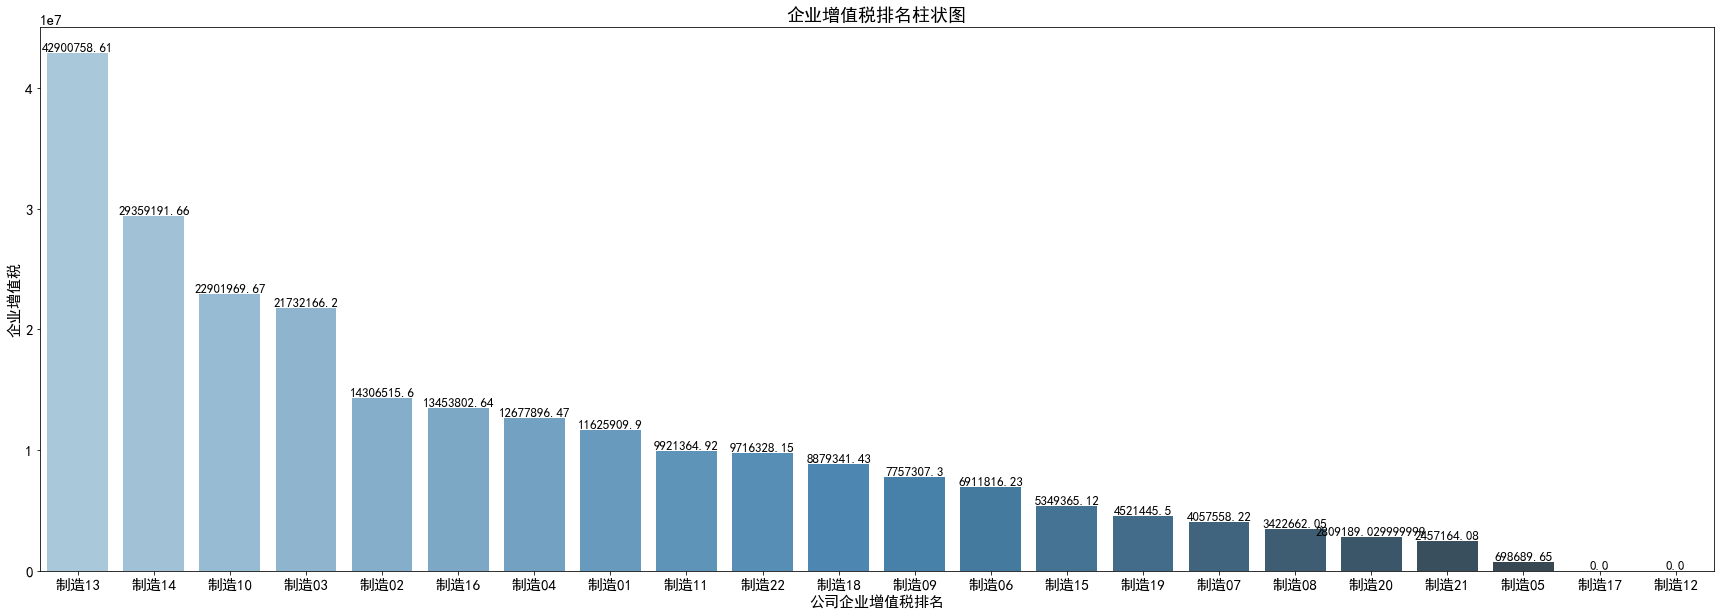

In [119]:
# 引入绘图颜色库
from matplotlib import colors
# 画企业增值税排名柱状图
plt.figure(figsize=(30, 10))
# 解决中文乱码问题
plt.rcParams['font.sans-serif'] = ['SimHei']
plt.rcParams['axes.unicode_minus'] = False
# 设置字体大小
plt.rcParams['font.size'] = 15

# 使用seaBorn绘制柱状图
sns.barplot(x='机构类型', y='企业增值税', data=manufacturing_data, palette='Blues_d')
# 设置x轴标签
plt.xlabel('公司企业增值税排名')
# 设置y轴标签
plt.ylabel('企业增值税')
# 设置标题
plt.title('企业增值税排名柱状图')
# 添加图注
for i in range(len(manufacturing_data)):
    plt.text(i, manufacturing_data['企业增值税'][i], manufacturing_data['企业增值税'][i], ha='center', va='bottom', fontsize=13)

# 显示图形
plt.show()
